<a href="https://colab.research.google.com/github/ryanraba/casa6/blob/master/CASA_imageclassifier_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imgpy > /dev/null
import urllib.request

print("downloading images...")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/examples.good.gif", "examples.good.gif")
urllib.request.urlretrieve("https://www.cv.nrao.edu/~rraba/examples.artifacts.gif", "examples.artifacts.gif")

downloading images...


('examples.artifacts.gif', <http.client.HTTPMessage at 0x7effde63c4a8>)

good count 682
bad count 1642
combined count 1364


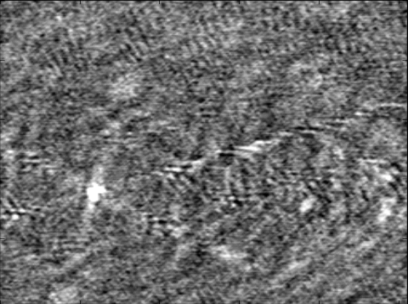

In [2]:
import PIL
import numpy as np
import imgpy
import matplotlib.pyplot as plt
np.random.seed(17)

# because the axes are in the image
crop_box = (171, 60, 651, 540)

# convert from raw image format to a numpy data matrix
# downsample a bit for speed (we're in a free cloud environment here)
images = imgpy.Img(fp='examples.good.gif').frames
dm = np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])
gc = len(images)
print('good count',gc)

images = imgpy.Img(fp='examples.artifacts.gif').frames
dm = np.concatenate((dm, np.array([np.array(dv.crop(crop_box).resize(size=(408,304), resample=PIL.Image.BILINEAR)) for dv in images])), axis=0)
print('bad count',len(images))

# lets balance the bad with the good so it's 50/50
# this makes the model accuracy more meaningful
dm = np.concatenate((dm[:gc], dm[np.random.choice(range(gc,len(dm)), gc, replace=False)]), axis=0 )
print('combined count', len(dm))

# normalize to 1
dm = dm[..., np.newaxis]/255.0

# create targets for binary classification (good = 1, bad = 0)
targets = np.concatenate((np.ones((int(len(dm)/2))), np.zeros((int(len(dm)/2)))), axis=0)

# sanity check
PIL.Image.fromarray(np.uint8(dm[gc+13][:,:,0]*255))

In [3]:
# randomly divide data in to training, validation, and test sets
# model is trained with train and validated with val
# test is saved for later as an independent holdout
np.random.seed(17)
train = np.random.choice(range(len(dm)), int(0.7*len(dm)), replace=False)
val = np.random.choice(np.setdiff1d(range(len(dm)), train), int(0.15*len(dm)), replace=False)
test = np.random.choice(np.setdiff1d(range(len(dm)), np.hstack((train, val))), int(0.15*len(dm)), replace=False)
print(len(dm), len(train), len(val), len(test))

1364 954 204 204


In [4]:
# here we build and train a CNN model
# lots of ways to do it, try different sizes, depths, activations, regularizations etc
# the loss/acc slope may be rocky, especially with lots of regularization/dropout
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, SpatialDropout2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping   

ins = Input(shape=(dm.shape[1], dm.shape[2], 1))
hh = Conv2D(16, (2, 2), activation='relu', padding='same')(ins)
hh = SpatialDropout2D(0.25)(hh)
hh = Conv2D(16, (2, 2), activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = SpatialDropout2D(0.25)(hh)
hh = Conv2D(8, (2, 2), activation='relu', padding='same')(hh)
hh = SpatialDropout2D(0.25)(hh)
hh = Conv2D(8, (2, 2), activation='relu', padding='same')(hh)
hh = MaxPooling2D(pool_size=2, strides=2, padding='same')(hh)
hh = Flatten()(hh)
hh = Dropout(0.25)(hh)
hh = Dense(128, activation='tanh')(hh)
outs = Dense(1, activation='sigmoid')(hh)

classifier = Model(ins, outs)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

classifier.fit(dm[train], targets[train], epochs=1000, batch_size=32, shuffle=True, verbose=1,
               validation_data=(dm[val], targets[val]),
               callbacks=[ModelCheckpoint('cnn_model.h5','val_acc',0, True, False),
                          EarlyStopping(monitor='val_acc', patience=6)])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 954 samples, validate on 204 samples
Epoch 1/1000
954/954 [==============================] - 9s 9ms/step - loss: 1.1290 - acc: 0.5042 - val_loss: 0.7237 - val_acc: 0.5000
Epoch 2/1000
954/954 [==============================] - 4s 4ms/step - loss: 0.6940 - acc: 0.5556 - val_loss: 0.6978 - val_acc: 0.5000
Epoch 3/1000
954/954 [==============================] - 4s 4ms/step - loss: 0.6840 - acc: 0.5608 - val_loss: 0.6802 - val_acc: 0.6225
Epoch 4/1000
954/954 [==============================] - 4s 4ms/step - loss: 0.6821 - acc: 0.5849 - val_loss: 0.6996 - val_acc: 0.5000
Epoch 5/1000
954/954 [==============================] - 4s 4ms/step - loss: 0.6696 - acc: 0.6080 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/1000
954/954 [===========================

classifier accuracy on train set 0.9916142557651991
classifier accuracy on val set 0.8676470588235294
classifier accuracy on test set 0.7549019607843137



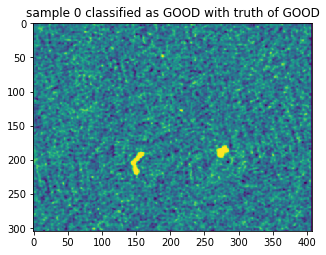

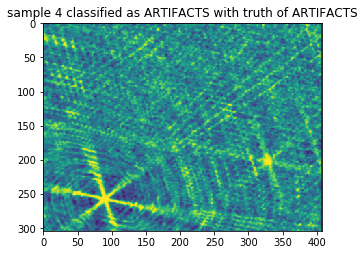

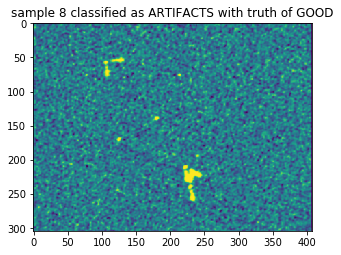

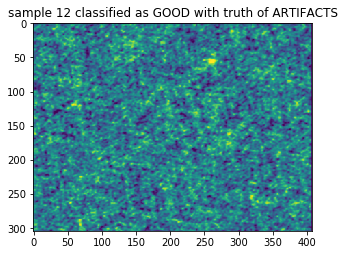

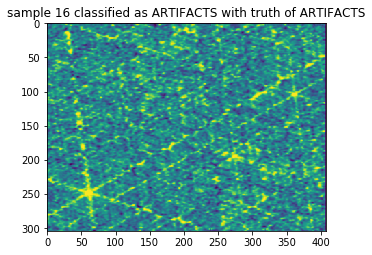

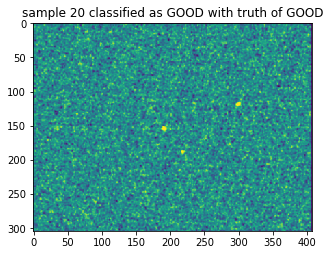

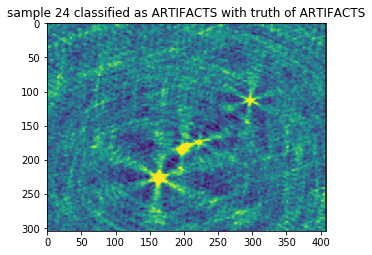

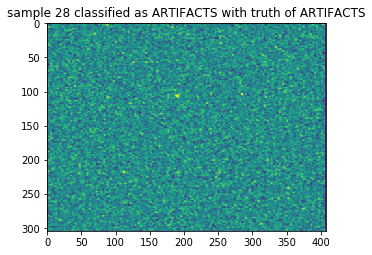

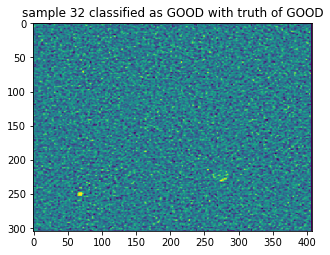

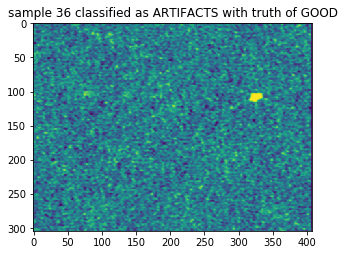

In [5]:
from matplotlib import colors
from sklearn.metrics import accuracy_score

# load best model saved during training
classifier = load_model('cnn_model.h5')

# just for kicks, lets verify training and validation accuracy first
preds = np.round(classifier.predict(dm[train]))
print('classifier accuracy on train set', accuracy_score(targets[train], preds))

preds = np.round(classifier.predict(dm[val]))
print('classifier accuracy on val set', accuracy_score(targets[val], preds))

# now the interesting part, lets see what the accuracy is on new data
preds = np.round(classifier.predict(dm[test]))
print('classifier accuracy on test set', accuracy_score(targets[test], preds))

# spot check some stuff
for ss in range(0,40,4):
  print('')
  ff, aa = plt.subplots(1,1, figsize=(5,5))
  label, truth = 'GOOD', 'GOOD'
  if preds[ss] == 0: label = 'ARTIFACTS'
  if targets[test[ss]] == 0: truth = 'ARTIFACTS'
  aa.imshow(dm[test[ss]][:,:,0], norm=colors.PowerNorm(1))
  aa.set_title('sample ' + str(ss) + ' classified as ' + label + ' with truth of ' + truth)
  plt.show()

# voila!